# Introduction to cuMl Random Forest and cuDF DataFrames (a CPU vs GPU-based model comparison)

RAPIDS is an open-source data analytics and machine learning acceleration platform which leverages Graphical Processing Units (GPUs) to accelerate computations. RAPIDS is based on Python, and mimics the APIs of popular data analytics and machine learning Python packages such as Pandas and Scikit-Learn. RAPIDS can scale from 1 to multi-GPU to multi-nodes. RAPIDS is particularly usefule because of it's end-end workflow - from data prep, to machine learning, to deep learning. 

In this notebook we will first discuss cuDF, the pandas-like data analytics and processing package. We will show how to import data from a csv to a GPU-based DataFrame. Then we will discuss and implement a simple Random Forest Classification model. We will train this Random Forest model from sample remote-sensing data. We will then save the Random Forest model and demonstrate how to load and reuse the model using [joblib](https://joblib.readthedocs.io/en/latest/) 

For additional information on RAPIDS cuDF, refer to the [cuDF docs](https://docs.rapids.ai/api/cudf/stable)

For additional information on RAPIDS cuML's Random Forest model, see [cuML Random Forest Regressor](https://docs.rapids.ai/api/cuml/stable/api.html#random-forest)

### What makes this demo different from Demo-1 is that we will be comparing CPU-based models vs GPU-based models.

In [1]:
import cudf
import cupy as cp
import numpy as np

from cuml.ensemble import RandomForestRegressor as curfr
from cuml import train_test_split as tts_gpu

import joblib
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as skrfr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split as tts_cpu
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import random

!nvidia-smi

Mon Dec 14 10:43:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:61:00.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:62:00.0 Off |                    0 |
| N/A   37C    P0    41W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Import Data

In this demo, we have the option of using one of two datasets ('aviris_bands_extract_final.csv', 'train_validate_10_final.csv') from the \'Data\' folder. This data is a sample of bands used to train our model to predict lake depth from raster data. 

The datasets are different in the fact that 'aviris_bands_extract_final' samples 390 spectral bands, while 'train_validate_10_final.csv' samples only 10. You can switch the notebook to use one of the two. 

Notice how well the GPU model deals with large data speed-wise. 

Note: Be wary that the permutation cell block will be very slow on the large dataset due to us using a cpu-based function. 

Notice the timing difference between a CPU-based read with a shift to GPU memory and a direct read to GPU memory.

In [2]:
%%time

df_pandas = pd.read_csv('Data/train_validate_10_final.csv').astype(np.float32) # A much smaller dataset
#df_pandas = pd.read_csv('Data/aviris_bands_extract_final.csv').astype(np.float32) # Read the csv into a pandas DataFrame
cudf_df = cudf.DataFrame.from_pandas(df_pandas).astype(np.float32) # Read the Pandas DF to GPU memory as a cuDF DataFrame


CPU times: user 1.86 s, sys: 1.63 s, total: 3.49 s
Wall time: 22.3 s


Since we were creating two seperate examples of the same data, we can get rid of one the first example.

Now that we have the dataset loaded into GPU memory. Let's poke around at our data using cuDF's handy functions. 

In [3]:
cudf_df.head(5)

,depth_m,b59_ang201,b60_ang201,b61_ang201,b62_ang201,b65_ang201,b67_ang201,b73_ang201,b74_ang201,b76_ang201,b78_ang201
0,0.766572,0.033982,0.033714,0.032013,0.031970,0.027843,0.024982,0.013986,0.014606,0.014061,0.014546
1,0.717804,0.033982,0.033714,0.032013,0.031970,0.027843,0.024982,0.013986,0.014606,0.014061,0.014546
2,0.859536,0.026502,0.026912,0.025114,0.025549,0.021589,0.020254,0.011278,0.011378,0.011042,0.011603
3,0.777240,0.027229,0.027591,0.025463,0.024831,0.021866,0.020672,0.012735,0.012505,0.012746,0.012870
4,0.649224,0.031175,0.031153,0.030272,0.029274,0.025335,0.023088,0.010361,0.011387,0.011305,0.011338


Looking at the above sample. We can see that we have the depth_m which will act as our training predictor. We also have 390 different AVIRIS bands to work with.

Since we're going to want to train with this data, we need to split the data up from the covariates (AVIRIS bands) and the training predictors (depth_m). We can do this very easily using the Pandas-like API.

In [4]:
cpu_training_predictors = df_pandas['depth_m']
cpu_covariates = df_pandas.drop(['depth_m'], axis=1)

gpu_training_predictors = cudf_df['depth_m']
gpu_covariates = cudf_df.drop(['depth_m'], axis=1)

That was simple. Now let's look at what we can do with some more cuDF functions. 

In [5]:
gpu_training_predictors.describe()

count    5243.000000
mean        1.373884
std         0.429527
min         0.470408
25%         1.099565
50%         1.475230
75%         1.743460
max         2.097020
Name: depth_m, dtype: float64

In [6]:
%%time

cpu_covariates.describe()

CPU times: user 31.2 ms, sys: 4.13 ms, total: 35.4 ms
Wall time: 32.6 ms


,b59_ang201,b60_ang201,b61_ang201,b62_ang201,b65_ang201,b67_ang201,b73_ang201,b74_ang201,b76_ang201,b78_ang201
count,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000
mean,0.031550,0.031185,0.029731,0.029375,0.026706,0.024247,0.013804,0.014180,0.014116,0.014009
std,0.004561,0.004575,0.004461,0.004481,0.004184,0.004098,0.003248,0.003330,0.003392,0.003391
min,0.022300,0.022247,0.021359,0.020706,0.017501,0.015925,0.004294,0.004750,0.004613,0.003249
25%,0.028299,0.027867,0.026529,0.026120,0.023692,0.021381,0.012834,0.013126,0.013113,0.013022
50%,0.030487,0.030170,0.028726,0.028313,0.025637,0.023053,0.013932,0.014245,0.014120,0.013994
75%,0.033626,0.033244,0.031814,0.031538,0.028830,0.026363,0.015050,0.015408,0.015316,0.015153
max,0.051969,0.051937,0.052641,0.053870,0.066151,0.079642,0.105788,0.107176,0.112849,0.115969


In [7]:
%%time

gpu_covariates.describe()

CPU times: user 288 ms, sys: 41.9 ms, total: 330 ms
Wall time: 2.18 s


,b59_ang201,b60_ang201,b61_ang201,b62_ang201,b65_ang201,b67_ang201,b73_ang201,b74_ang201,b76_ang201,b78_ang201
count,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000
mean,0.031550,0.031185,0.029731,0.029375,0.026706,0.024247,0.013804,0.014180,0.014116,0.014009
std,0.004561,0.004575,0.004461,0.004481,0.004184,0.004098,0.003248,0.003330,0.003392,0.003391
min,0.022300,0.022247,0.021359,0.020706,0.017501,0.015925,0.004294,0.004750,0.004613,0.003249
25%,0.028299,0.027867,0.026529,0.026120,0.023692,0.021381,0.012834,0.013126,0.013113,0.013022
50%,0.030487,0.030170,0.028726,0.028313,0.025637,0.023053,0.013932,0.014245,0.014120,0.013994
75%,0.033626,0.033244,0.031814,0.031538,0.028830,0.026363,0.015050,0.015408,0.015316,0.015153
max,0.051969,0.051937,0.052641,0.053870,0.066151,0.079642,0.105788,0.107176,0.112849,0.115969


In order to train and test the Random Forest model, we'll need to split the data into training and testing data. Fortunately, cuML implements this function, which operates exactly like Scikit-Learn's `train_test_split`

### Data splitting

In [8]:
X_pd_train, X_pd_test, y_pd_train, y_pd_test = tts_cpu(cpu_covariates,
                                                     cpu_training_predictors,
                                                     shuffle=True,
                                                     train_size=0.8)

In [9]:
X_cudf_train, X_cudf_test, y_cudf_train, y_cudf_test = tts_gpu(gpu_covariates, 
                                                                gpu_training_predictors, 
                                                                shuffle=True, 
                                                                train_size = 0.8)

In [10]:
print('Training features shape: ', X_pd_train.shape)
print('Training labels shape: ', y_pd_train.shape)
print('Testing features shape: ', X_pd_test.shape)
print('Testing labels shape: ', y_pd_test.shape)

Training features shape:  (4194, 10)
Training labels shape:  (4194,)
Testing features shape:  (1049, 10)
Testing labels shape:  (1049,)


## Scikit Random Forest Regressor

### Fit

In [11]:
%%time

sk_model = skrfr(n_estimators = 1000,
                max_depth = 50,
                max_features= 'auto',
                random_state= 42
                )

sk_model.fit(X_pd_train, y_pd_train)

CPU times: user 29.9 s, sys: 264 ms, total: 30.1 s
Wall time: 30.1 s


RandomForestRegressor(max_depth=50, n_estimators=1000, random_state=42)

### Evaluate

In [12]:
%%time

sk_predict = sk_model.predict(X_pd_test)

mae_sk_model = mean_squared_error(y_pd_test, sk_predict)
r2_sk_model = r2_score(y_pd_test, sk_predict)

CPU times: user 279 ms, sys: 42.6 ms, total: 322 ms
Wall time: 319 ms


## cuML Random Forest Regressor

Here we're going to initialize and fit the cuML model. Given the speed-up we get from GPU-based computations, we can afford a large Random Forest. 

Note: Igonore the warnings you may get with this.

### Fit

In [13]:
%%time

cuml_model = curfr(n_estimators=1000,
                  max_depth = 50,
                  max_features = 'auto',
                  random_state = 42)

cuml_model.fit(X_cudf_train, y_cudf_train)

/home/cssprad1/.conda/envs/rapids-0.16/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  after removing the cwd from sys.path.


CPU times: user 7.1 s, sys: 4.68 s, total: 11.8 s
Wall time: 4.99 s


RandomForestRegressor(split_criterion=2, accuracy_metric='r2', handle=<cuml.raft.common.handle.Handle object at 0x7f41938592d0>, verbose=4, output_type='cudf')

### Evaluate

In [14]:
%%time

predictions = cuml_model.predict(X_cudf_test)

mae_cuml_model = mean_squared_error(y_cudf_test.to_array(), predictions.to_array())
r2_cuml_model = r2_score(y_cudf_test.to_array(), predictions.to_array())

CPU times: user 2.59 s, sys: 807 ms, total: 3.39 s
Wall time: 3.34 s


# Compare and examine results

### Compare CPU vs GPU

In [15]:
print('CUML mean absolute error of RF model before saving: %s' % mae_cuml_model)
print('Scikit mean absolute error of RF model after saving: %s' % mae_sk_model)

print('CUML r^2 score of RF model before saving: %s' % r2_cuml_model)
print('Scikit r^2 score of RF model after saving: %s' % r2_sk_model)

CUML mean absolute error of RF model before saving: 0.06138272
Scikit mean absolute error of RF model after saving: 0.04066270090645786
CUML r^2 score of RF model before saving: 0.6480579788950331
Scikit r^2 score of RF model after saving: 0.7709870112021907


## Results Visualization

Here we can use JupyterHub to examine plots inline.

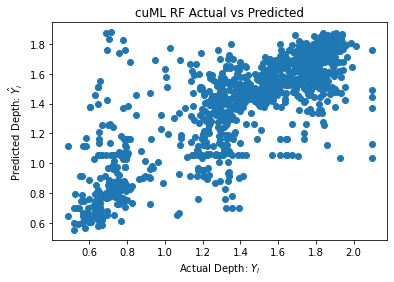

In [16]:
plt.scatter(y_cudf_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("cuML RF Actual vs Predicted")
plt.show()

Let's look at a random sample of datapoints to see the actual vs predicted depths

In [17]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
for i in range(20):
    random_data_point = random.randint(0, 1048)
    print('Data-point: {:5} Actual: {:20} Predicted: {}'.format(random_data_point, y_cudf_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:   416 Actual:   1.7556500434875488 Predicted: 1.7169930934906006
Data-point:  1030 Actual:    1.728219985961914 Predicted: 1.7078977823257446
Data-point:   416 Actual:   1.7556500434875488 Predicted: 1.7169930934906006
Data-point:   544 Actual:    1.609339952468872 Predicted: 1.4851900339126587
Data-point:   157 Actual:   1.2202199697494507 Predicted: 1.0564881563186646
Data-point:   212 Actual:   0.7254239916801453 Predicted: 0.9852567315101624
Data-point:    96 Actual:   0.7640320062637329 Predicted: 1.0556926727294922
Data-point:   401 Actual:   1.3898899555206299 Predicted: 0.901450514793396
Data-point:   669 Actual:   0.6370319724082947 Predicted: 0.8520861268043518
Data-point:    74 Actual:   1.4110000133514404 Predicted: 0.9148826003074646
Data-point:   445 Actual:   1.0744199752807617 Predicted: 0.9252614378929138
Data-point:   615 Actual:    1.321310043334961 Predicted: 1.187759280204773
Data-point:   194 Actual:   1.1765300035476685 Predicted: 1.0812634229660034
D

# Using sklearn with GPU models

### We can use most of sklearn's tools on our cuML models, one example being permutation importance!

Find the permutation importance using sklearn's implementation (works with cuML models)

Note: Be wary of running this with the 390 band dataset, it could take a VERY long time...

In [18]:
%%time

perm_imp = permutation_importance(cuml_model, X_cudf_test, y_cudf_test)
spectral_bands_list = list(gpu_covariates.columns)
importances = perm_imp.importances_mean
feature_importances = [(feature, (round(importance, 5))) for
                      feature, importance in zip(spectral_bands_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
_ = [print('Variables: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variables: b73_ang201           Importance: 0.46938
Variables: b67_ang201           Importance: 0.32985
Variables: b78_ang201           Importance: 0.29206
Variables: b61_ang201           Importance: 0.24136
Variables: b59_ang201           Importance: 0.19638
Variables: b60_ang201           Importance: 0.19358
Variables: b65_ang201           Importance: 0.12082
Variables: b74_ang201           Importance: 0.10875
Variables: b76_ang201           Importance: 0.07539
Variables: b62_ang201           Importance: 0.0428
CPU times: user 12.3 s, sys: 1.99 s, total: 14.3 s
Wall time: 14.3 s
